# Comparing Transect Data at the Tanana River Test Site 

The following example will familiarize the user with the MHKiT DOLfYN and Delft3D modules by performing a Deflt3d numerical model validation of the Tanana River Test Site against field data.

Start by importing the necessary python packages and MHKiT module.

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from matplotlib.pyplot import figure
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from datetime import datetime
from dolfyn.adp import api
import xarray as xr
import pandas as pd
import numpy as np
import scipy.io
import netCDF4
import math 
import utm
# MHKiT Imports
from mhkit.dolfyn.rotate import api as ap
from mhkit import dolfyn as dlfn
from mhkit.river.io import d3d 
from mhkit import river

c:\users\eabrow\codes\mhkit-python\mhkit\dolfyn\velocity.py:11: AccessorRegistrationWarning: registration of accessor <class 'mhkit.dolfyn.velocity.Velocity'> under name 'velds' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class Velocity():


## Preparing the Field Data

Field data was collected in 2010. As can be seen below 2 passes were collected across the river. In the next section we will import this data into MHKiT and then interpolate these two passes into a single idealized transect for comparison with the simulated Deflt3D data.

<img src="TRTS_transect_map.png" width=720 height=640 />

### Importing ADCP Data

The MHKiT DOLfYN api module can import .PDO and other ADCP and ADV binary formats to an xarray. For this analysis we import two transect passes stored in the 'data' folder in .PDO format. For comparison to the numerical model we want to average the two transects into one xarray ('transect_1_2').

In [2]:
# Read in the two transect passes
transect_1_raw = api.read('data/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0') 
transect_2_raw = api.read('data/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0')
# Create one dataset from the two passes
transect_1_2= xr.merge([transect_1_raw, transect_2_raw])
# Print the xarray data
transect_1_2


Reading file data/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0 ...

Reading file data/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0 ...


<xarray.Dataset>
Dimensions:              (time_gps: 1180, time: 1180, beam: 4, dir: 4, range: 47, x: 4, x*: 4, earth: 3, inst: 3)
Coordinates:
  * time_gps             (time_gps) datetime64[ns] 2010-08-10T22:28:17.200000...
  * time                 (time) datetime64[ns] 2010-08-10T14:28:15.559999942 ...
  * beam                 (beam) int32 1 2 3 4
  * dir                  (dir) <U3 'X' 'Y' 'Z' 'err'
  * range                (range) float64 0.57 0.82 1.07 ... 11.57 11.82 12.07
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables: (12/36)
    number               (time) float64 3.652e+03 3.653e+03 ... 4.904e+03
    builtin_test_fail    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    c_sound              (time) float32 1.466e+03 1.466e+03 ... 1.466e+03
    depth                (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pitch                (time) float32 -0.1 -0.09 -0.21 -0.25 ... 0.2 0.07 0.56
    roll                 (time) float32 3.33 3.32 3.33 3.49 ... 2.24 2.65 2.33
    ...                   ...
    rtk_age_gps          (time_gps) float32 5.0 6.0 2.0 3.0 ... 6.0 2.0 3.0 3.0
    speed_over_grnd_gps  (time_gps) float32 0.03549 0.03395 ... 0.1096 0.1672
    dir_over_grnd_gps    (time_gps) float32 115.5 94.08 6.931 ... 160.5 182.1
    hdwtime_gps          (time_gps) datetime64[ns] 2010-08-10T14:28:15.559999...
    beam2inst_orientmat  (x, x*) float64 1.462 -1.462 0.0 ... -1.034 -1.034
    orientmat            (earth, inst, time) float64 -0.9037 -0.9025 ... 1.0 1.0
Attributes: (12/38)
    inst_make:                TRDI
    inst_type:                ADCP
    rotate_vars:              ['vel', 'vel_bt']
    has_imu:                  0
    prog_ver:                 10.16
    inst_model:               Rio Grande
    ...                       ...
    false_target_threshold:   50
    transmit_lag_m:           0.08
    bandwidth:                0
    sourceprog:               WINRIVER
    fs:                       11.11111111111111
    vel_gps_corrected:        0

### Convert the the coordinate system to UTM

The ADCP location data is stored in longitude and latitude coordinates by default. However, latitude and longitude cannot be directly converted to a distance therefor here we convert from latitude and longitude to $UTM_x$ and $UTM_y$. This gives us the ability to calculate the linear line of best fit for the idealized transect.

In [3]:
utm_x_y=utm.from_latlon(transect_1_2.latitude_gps, transect_1_2.longitude_gps, 6, 'W') # combined transects 

gps = np.array([
    [x, y] for x, y in zip(utm_x_y[0], utm_x_y[1])
    ]) 
gps_points = pd.DataFrame(gps, columns= ['utm_x','utm_y'])

### Ideal Transect 


Calculate ideal linear transect using combined transect_1_2 data set. Using the numpy polyfit function to find the slop and intercept we can then use those to recalculate the $UTM_y$coordinated to be the ideal linear transect.

Text(0, 0.5, 'UTM y (m)')

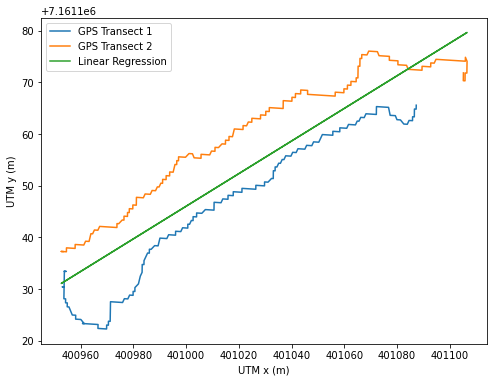

In [4]:
# Linear regression using first order polyfit
a,b = np.polyfit(gps_points.utm_x, gps_points.utm_y,1)


ideal= np.array([ 
    [x, y] for x, y in zip(gps_points.utm_x, a*gps_points.utm_x+b)
    ]) 
ideal_points = pd.DataFrame(ideal, columns= ['utm_x','utm_y'])


#repeat UTM corrdinates to match the ADCP points matrix (dir, range, time)
utm_x_points = np.tile(gps_points.utm_x, np.size(transect_1_2.range))
utm_y_points = np.tile(a*gps_points.utm_x+b, np.size(transect_1_2.range))
depth_points = np.repeat( transect_1_2.range, np.size(gps_points.utm_x))

ADCP_ideal_points={
    'utm_x': utm_x_points, 
    'utm_y': utm_y_points, 
    'waterdepth': depth_points
    }
ADCP_ideal_points=pd.DataFrame(ADCP_ideal_points)

# Initialize the figure
figure(figsize=(8,6))

# Plot the original transect data for comparison
transect_1 = utm.from_latlon(transect_1_raw.latitude_gps, transect_1_raw.longitude_gps, 6, 'W') 
transect_2 =utm.from_latlon(transect_2_raw.latitude_gps, transect_2_raw.longitude_gps, 6, 'W') 

plt.plot(transect_1[0],transect_1[1], label= 'GPS Transect 1')
plt.plot(transect_2[0],transect_2[1], label= 'GPS Transect 2')

# Plot the Idealized Transect
plt.plot(ADCP_ideal_points.utm_x,ADCP_ideal_points.utm_y, label= 'Linear Regression')
plt.legend()
plt.xlabel('UTM x (m)')
plt.ylabel('UTM y (m)')

### Range offset

Depeding on where the ADCP is deployed the `range` values might need to be offset by the the deploment depth. In this case the range had already been corrected so a zero input as an example. 

In [5]:
# What is this doing?
api.clean.set_range_offset(transect_1_2,0)
# why is this being shown?
transect_1_2.range

<xarray.DataArray 'range' (range: 47)>
array([ 0.57,  0.82,  1.07,  1.32,  1.57,  1.82,  2.07,  2.32,  2.57,  2.82,
        3.07,  3.32,  3.57,  3.82,  4.07,  4.32,  4.57,  4.82,  5.07,  5.32,
        5.57,  5.82,  6.07,  6.32,  6.57,  6.82,  7.07,  7.32,  7.57,  7.82,
        8.07,  8.32,  8.57,  8.82,  9.07,  9.32,  9.57,  9.82, 10.07, 10.32,
       10.57, 10.82, 11.07, 11.32, 11.57, 11.82, 12.07])
Coordinates:
  * range    (range) float64 0.57 0.82 1.07 1.32 ... 11.32 11.57 11.82 12.07
Attributes:
    units:    m

### Correlation filter 
Data is fileted for a minimum correlation of 40 counts.  Beam correlation is an indicatior of the data quality as a ratio of signal to noise. 

Data is already in the earth coordinate system


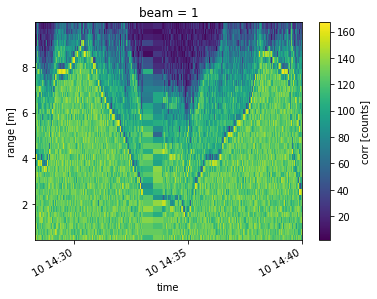

In [29]:
api.rotate2(transect_1_2, 'earth', inplace=True)
transect_1_2 = api.clean.correlation_filter(transect_1_2, thresh=40)
transect_1_2.corr.sel(beam=1, range=slice(0,10)).plot() #considering removing this plot since it's upsidedown and in the ADCP example 

### Declination 

If your declination is not already set you can correct for declination with the MHKIT DOLfYN ap's set_declination. If it was already been set with the deployment software it will be saved under the attributes  `magnetic_var_deg` for Teledyne instruments. 

In [7]:
ap.set_declination(transect_1_2, 15.7, inplace=True) # 15.7 deg East for Nenana Alaska 

### Bottom Filter 
MHKiT DOLfYN has the functionality to find the river bottom based on the along-beam acoustic amplitude data recorded from the ADCP. However, if depth sounder data is available it can be more reliable at representing the river bottom. Here we use the depth sounder `depth_sounder` to create an array that can be used as a filter when multiplied with the velocity data.

In [8]:
# Explain inline what is happening
depth_sounder = transect_1_2.where(transect_1_2.dist_bt > 0 )
bottom=np.min(depth_sounder.dist_bt,axis=0)
bottom_avg= interp.griddata(gps_points,bottom,ideal_points, method='linear')
bottom_filter = d3d.create_points(x=bottom_avg, y=transect_1_2.range.to_numpy(), waterdepth=1)
river_bottom_filter= []

for index, row in  bottom_filter.iterrows():
    if row['x'] > row['y']: 
        filter = 1    
    else: 
        filter= float("nan")
    river_bottom_filter= np.append(river_bottom_filter, filter)

[0, 1, 2]


### Original Transect Data 

To properly interpolate the velocity data onto the ideal transect the location and velocity data must be formated properly. 

In [9]:
# what are these tiles doing?
gps_utm_x= np.tile(gps_points.utm_x, np.size(transect_1_2.range))
gps_utm_y= np.tile(gps_points.utm_y, np.size(transect_1_2.range))
depth =np.repeat( transect_1_2.range,np.size(gps_points.utm_x))
ADCP_points={'utm_x': gps_utm_x, 'utm_y': gps_utm_y, 'waterdepth': depth}
ADCP_points=pd.DataFrame(ADCP_points)

ADCP_points['north_velocity']= np.ravel(transect_1_2.vel[1, :,:])* river_bottom_filter
ADCP_points['east_velocity']= np.ravel(transect_1_2.vel[0, :,:])* river_bottom_filter
ADCP_points['vertical_velocity']= np.ravel(transect_1_2.vel[2, :,:])* river_bottom_filter
ADCP_points= ADCP_points.dropna()
# Show points
ADCP_points

,utm_x,utm_y,waterdepth,north_velocity,east_velocity,vertical_velocity
0,400953.813014,7.161133e+06,0.57,0.214233,-0.094245,-0.010
1,400953.813014,7.161133e+06,0.57,0.079026,0.181185,0.022
2,400953.813014,7.161133e+06,0.57,0.129486,-0.143789,-0.119
3,400953.813014,7.161133e+06,0.57,0.519561,-0.432847,-0.095
4,400953.813014,7.161133e+06,0.57,0.393507,-0.258352,-0.106
...,...,...,...,...,...,...
37594,400992.412805,7.161152e+06,8.32,0.560519,0.381595,0.104
37597,400991.734048,7.161151e+06,8.32,0.515059,0.058718,0.152
37598,400991.079108,7.161151e+06,8.32,1.154619,0.520316,0.084
37599,400991.079108,7.161151e+06,8.32,1.282981,0.194119,0.123


### Ideal Transect Downsampled

As the collected ADCP data had far more resolution than the numerical model a down-sampling was applied using an average to match the locations at which the Delft3D model returned data. 

In [10]:
# Interpolate points by getting min & max first
stat_utmx = min(ADCP_ideal_points.utm_x)
start_utmy= min(ADCP_ideal_points.utm_y)

end_utmx= max(ADCP_ideal_points.utm_x)
end_utmy= min(ADCP_ideal_points.utm_y)

utm_x_ideal_downsampeled = np.linspace(stat_utmx,end_utmx,10)
utm_y_ideal_downsampeled= a*utm_x_ideal_downsampeled+b

In [11]:
utm_x_ideal_points_downsampled= np.tile(utm_x_ideal_downsampeled, np.size(transect_1_2.range))
utm_y_ideal_points_downsampled= np.tile(utm_y_ideal_downsampeled, np.size(transect_1_2.range))
depth_ideal_points_downsampled =np.repeat(transect_1_2.range,np.size(utm_x_ideal_downsampeled))

ADCP_ideal_points_downsamples={'utm_x': utm_x_ideal_points_downsampled, 'utm_y': utm_y_ideal_points_downsampled, 'waterdepth': depth_ideal_points_downsampled}
ADCP_ideal_points_downsamples=pd.DataFrame(ADCP_ideal_points_downsamples)
ADCP_ideal_points_downsamples

,utm_x,utm_y,waterdepth
0,400952.628168,7.161131e+06,0.57
1,400969.724752,7.161136e+06,0.57
2,400986.821336,7.161142e+06,0.57
3,401003.917920,7.161147e+06,0.57
4,401021.014504,7.161153e+06,0.57
...,...,...,...
465,401038.111088,7.161158e+06,12.07
466,401055.207672,7.161163e+06,12.07
467,401072.304256,7.161169e+06,12.07
468,401089.400839,7.161174e+06,12.07


# Interpolating Velocities for Ideal Transect 

In [12]:
# Project velocity onto ideal tansect 
ADCP_ideal= pd.DataFrame()
ADCP_ideal['east_velocity']=  interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['east_velocity'],
    ADCP_ideal_points[['utm_x','utm_y','waterdepth']],
    method='linear',
    fill_value=0
    )
ADCP_ideal['north_velocity']= interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['north_velocity'],
    ADCP_ideal_points[['utm_x','utm_y','waterdepth']],
    method='linear',
    fill_value=0
    )
ADCP_ideal['vertical_velocity']=  interp.griddata(
        ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['vertical_velocity'],
    ADCP_ideal_points[['utm_x','utm_y','waterdepth']],
    method='linear',
    fill_value=0
    )
ADCP_ideal['magnitude']= np.sqrt(ADCP_ideal.east_velocity**2+ADCP_ideal.north_velocity**2+ADCP_ideal.vertical_velocity**2)
ADCP_ideal

,east_velocity,north_velocity,vertical_velocity,magnitude
0,0.114523,0.34273,-0.001757,0.361362
1,0.114523,0.34273,-0.001757,0.361362
2,0.114523,0.34273,-0.001757,0.361362
3,0.114523,0.34273,-0.001757,0.361362
4,0.114523,0.34273,-0.001757,0.361362
...,...,...,...,...
55455,0.000000,0.00000,0.000000,0.000000
55456,0.000000,0.00000,0.000000,0.000000
55457,0.000000,0.00000,0.000000,0.000000
55458,0.000000,0.00000,0.000000,0.000000


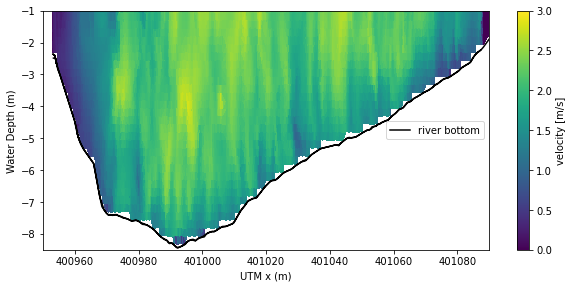

In [13]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_ideal_points.utm_x, 
    -ADCP_ideal_points.waterdepth, 
     ADCP_ideal.magnitude*river_bottom_filter,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8.5,-1])
plt.xlim([400950,401090])
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')
plt.legend(loc= 7)

# Interpolating Downsampled Velocites for Ideal Transect 

In [14]:
utm_x_downsampeled = np.linspace(stat_utmx,end_utmx,10)
utm_y_downsampeled= a*utm_x_downsampeled+b

ideal_downsampeled= np.array([ [x, y] for x, y in zip(utm_x_downsampeled,
                            utm_y_downsampeled)]) 
ideal_points_downsampled = pd.DataFrame(ideal_downsampeled, columns= ['utm_x','utm_y'])

bottom_avg_downsampled= interp.griddata(gps_points, bottom, ideal_points_downsampled, method='linear')
bottom_filter_downsampled = d3d.create_points(x=bottom_avg_downsampled, y=transect_1_2.range.to_numpy(), waterdepth=1)
river_bottom_filter_downsampled= []

for index, row in  bottom_filter_downsampled.iterrows():
    if row['x'] > row['y']: 
        filter= 1
    
    else: 
        filter= float("nan")
    river_bottom_filter_downsampled= np.append(river_bottom_filter_downsampled, filter)

[0, 1, 2]


In [20]:
# Project velocity onto ideal tansect  
ADCP_ideal_downsamples= pd.DataFrame()
ADCP_ideal_downsamples['east_velocity']=  interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['east_velocity'],
    ADCP_ideal_points_downsamples[['utm_x','utm_y','waterdepth']],
    method='linear',
    fill_value=0
    )
ADCP_ideal_downsamples['north_velocity']= interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['north_velocity'],
    ADCP_ideal_points_downsamples[['utm_x','utm_y','waterdepth']],
    method='linear',
    fill_value=0
    )
ADCP_ideal_downsamples['vertical_velocity']=  interp.griddata(
        ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['vertical_velocity'],
    ADCP_ideal_points_downsamples[['utm_x','utm_y','waterdepth']],
    method='linear',
    fill_value=0
    )
ADCP_ideal_downsamples['magnitude']= np.sqrt(ADCP_ideal_downsamples.east_velocity**2+ADCP_ideal_downsamples.north_velocity**2+ADCP_ideal_downsamples.vertical_velocity**2)
ADCP_ideal_downsamples

,east_velocity,north_velocity,vertical_velocity,magnitude
0,0.000000,0.000000,0.000000,0.000000
1,-0.392040,1.382162,0.099849,1.440152
2,-0.887436,1.839631,0.001920,2.042496
3,-0.946890,2.343597,-0.048898,2.528129
4,-0.968838,2.080335,-0.036601,2.295165
...,...,...,...,...
465,0.000000,0.000000,0.000000,0.000000
466,0.000000,0.000000,0.000000,0.000000
467,0.000000,0.000000,0.000000,0.000000
468,0.000000,0.000000,0.000000,0.000000


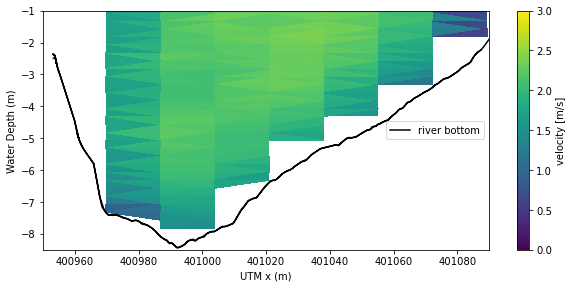

In [21]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_ideal_points_downsamples.utm_x, 
    -ADCP_ideal_points_downsamples.waterdepth, 
     ADCP_ideal_downsamples.magnitude*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8.5,-1])
plt.xlim([400950,401090])
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')
plt.legend(loc= 7)

# USGS Water Level

In [22]:
# Use the requests method to obtain 10 years of daily discharge data
data = river.io.usgs.request_usgs_data(station="15515500",
                            parameter='00065',
                            start_date='2010-08-10',
                            end_date='2010-08-10',
                            data_type='Instantaneous')

# Print data
print(data)

Data request URL:  https://waterservices.usgs.gov/nwis/iv/?format=json&sites=15515500&startDT=2010-08-10&endDT=2010-08-10&parameterCd=00065&siteStatus=all
                           Gage height, feet
2010-08-10 08:00:00+00:00               8.96
2010-08-10 08:15:00+00:00               8.99
2010-08-10 08:30:00+00:00               8.94
2010-08-10 08:45:00+00:00               8.96
2010-08-10 09:00:00+00:00               9.00
...                                      ...
2010-08-11 06:45:00+00:00               8.89
2010-08-11 07:00:00+00:00               8.89
2010-08-11 07:15:00+00:00               8.89
2010-08-11 07:30:00+00:00               8.91
2010-08-11 07:45:00+00:00               8.91

[96 rows x 1 columns]


 # Delft3D data

In [23]:
# Simulated data
# Downloading Data
d3d_data = netCDF4.Dataset('data/tanana81010_final_map.nc')

In [24]:
# Printing variable and description
for var in d3d_data.variables.keys():
    try: 
        d3d_data[var].long_name
    except:
        print(f'"{var}"')        
    else:
        print(f'"{var}": {d3d_data[var].long_name}')

"mesh2d_enc_x": x-coordinate
"mesh2d_enc_y": y-coordinate
"mesh2d_enc_node_count": count of coordinates in each instance geometry
"mesh2d_enc_part_node_count": count of nodes in each geometry part
"mesh2d_enc_interior_ring": type of each geometry part
"mesh2d_enclosure_container"
"Mesh2D"
"NetNode_x": x-coordinate
"NetNode_y": y-coordinate
"projected_coordinate_system"
"NetNode_z": bed level at net nodes (flow element corners)
"NetLink": link between two netnodes
"NetLinkType": type of netlink
"NetElemNode": mapping from net cell to net nodes (counterclockwise)
"NetElemLink": mapping from net cell to its net links (counterclockwise)
"NetLinkContour_x": list of x-contour points of momentum control volume surrounding each net/flow link
"NetLinkContour_y": list of y-contour points of momentum control volume surrounding each net/flow link
"NetLink_xu": x-coordinate of net link center (velocity point)
"NetLink_yu": y-coordinate of net link center (velocity point)
"BndLink": netlinks that co

In [25]:
ADCP_ideal_points_downsamples_xy= ADCP_ideal_points_downsamples.rename(columns={"utm_x": "x", "utm_y": "y"})

In [26]:
variables= ['ucy', 'ucx','ucz']
D3d= d3d.variable_interpolation(d3d_data, variables, points= ADCP_ideal_points_downsamples_xy)

points provided


In [27]:
D3d['magnitude']=  np.sqrt(D3d.ucy**2+D3d.ucx**2+D3d.ucz**2)

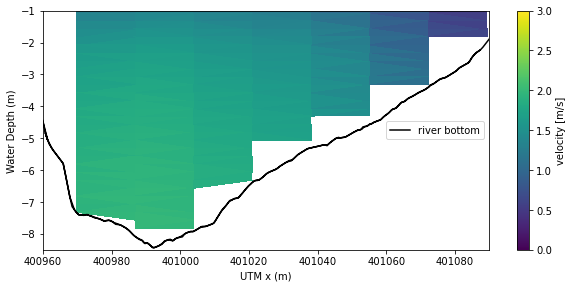

In [31]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    D3d.magnitude*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot,
    #shading='gouraud'
    alpha=1
)
#*river_bottom_filter_downsampled

plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
#plt.title('Velocity in the Y direction')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8.5,-1])
plt.xlim([400960,401090])
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')
plt.legend(loc= 7)

# L1 Error Calulations

In [35]:
# L1
L1_Magnitude= abs(ADCP_ideal_downsamples.magnitude-D3d.magnitude)/ADCP_ideal_downsamples.magnitude


In [36]:
bottom_filter_downsampled= []
for i in  L1_Magnitude:
    if 1 > i: 
        filter= 1
    
    else: 
        filter= float("nan")
    bottom_filter_downsampled= np.append(bottom_filter_downsampled, filter)

0.26428320272152805

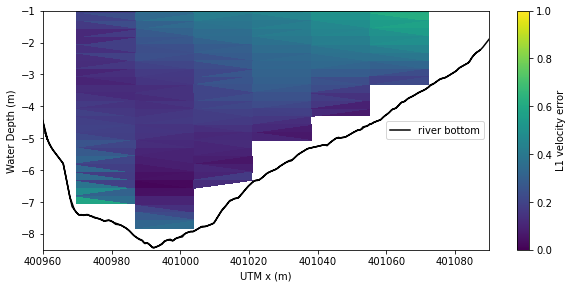

In [38]:
max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L1 = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    L1_Magnitude*bottom_filter_downsampled*river_bottom_filter_downsampled,
        vmin=min_plot,
    vmax=max_plot
)

plt.xlim([400960,401090])
plt.ylim([-8.5,-1])
plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
#plt.title('L1 error between Delft3D and ADCP data for North velocity')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('L1 velocity error')
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')
plt.legend(loc= 7)

MAE= np.sum(L1_Magnitude*bottom_filter_downsampled*river_bottom_filter_downsampled)/len(L1_Magnitude[L1_Magnitude< 1000 ])
MAE

# L2 Error Calculations

0.10376043394958755


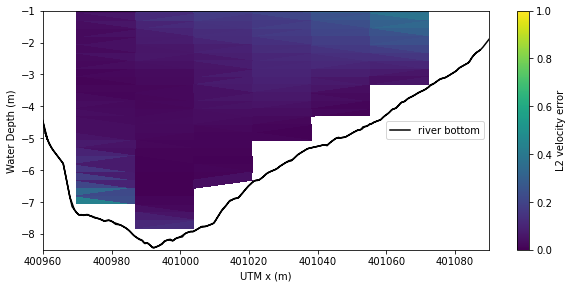

In [41]:
# L2 

L2_Magnitude= ((ADCP_ideal_downsamples.magnitude-D3d.magnitude)/ADCP_ideal_downsamples.magnitude)**2

MSE=np.sum(L2_Magnitude*bottom_filter_downsampled*river_bottom_filter_downsampled)/np.size(L2_Magnitude[L2_Magnitude< 1000])

print(MSE)
L2_Mag=L2_Magnitude[L2_Magnitude>1]= float('nan')

max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L2 = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    L2_Magnitude*bottom_filter_downsampled*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlim([400960,401090])
plt.ylim([-8.5,-1])
plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
#plt.title('L2 error between Delft3D and ADCP data for North velocity')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('L2 velocity error')
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')
plt.legend(loc= 7)

In [42]:
# L inf

L_inf=np.nanmax(L1_Magnitude[L1_Magnitude< 1000 ])
L_inf

0.8107368129137972